## Parse Steam APIs and Plot Time Series Graphs

1. Enter Game ID, month range to plot etc.
2. Go to Runtime > Run All
3. Generate Graphs, save with right-click

In [65]:
# Parameters: game ID, months range, and whether to smooth
game_id = 1091500  # Steam Store ID of game to track
months_range = 0 # Track N months from release date; Set to 6, 12, 24, or 0 for all time
smooth = False  # Set to True for rolling mean smoothing of time series data; False for raw data

Game Reviews:


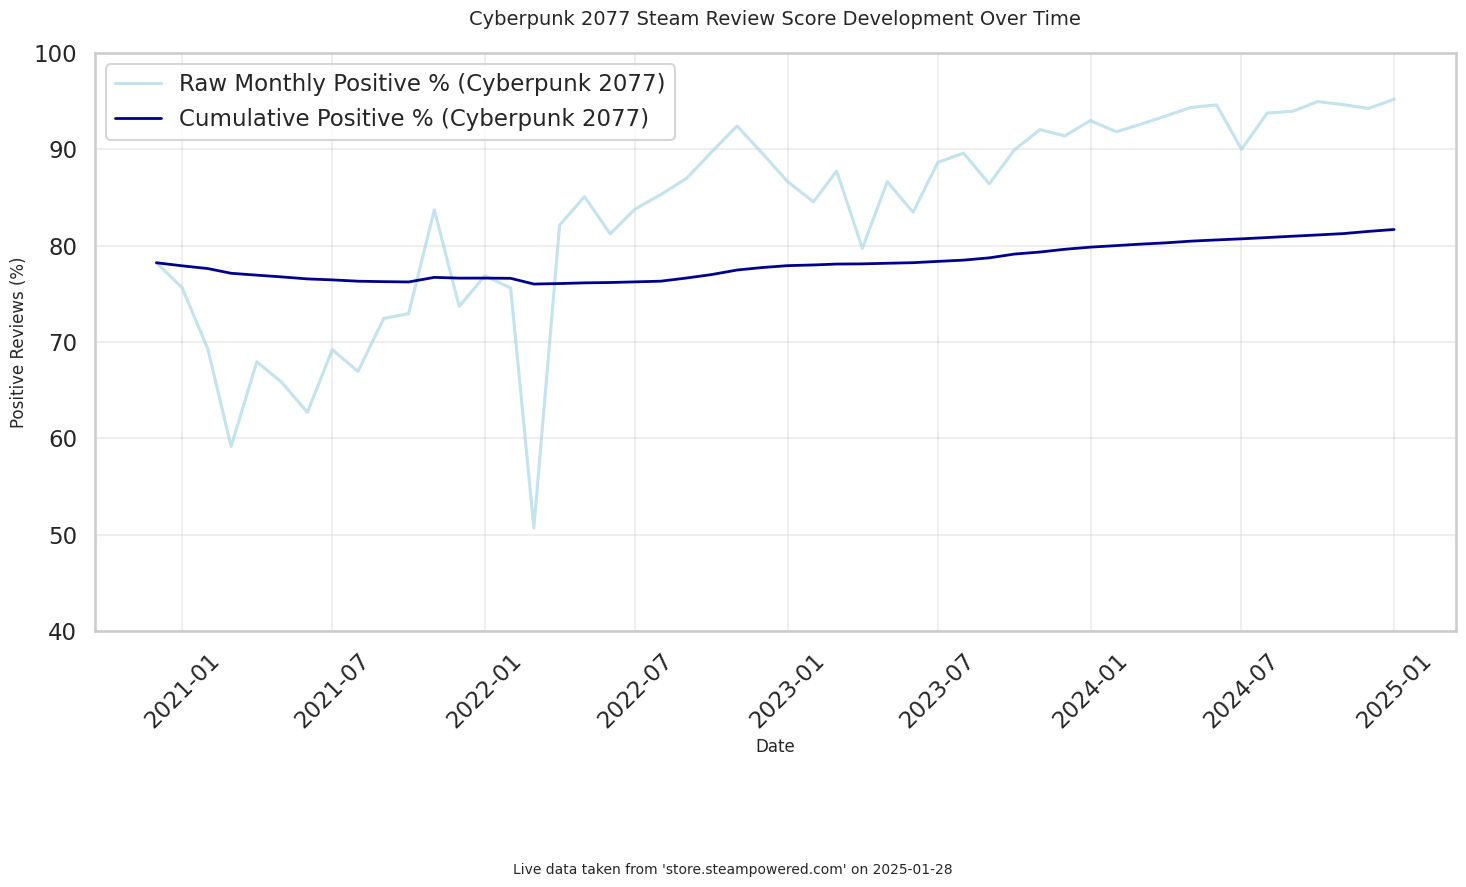

Concurrent Users:


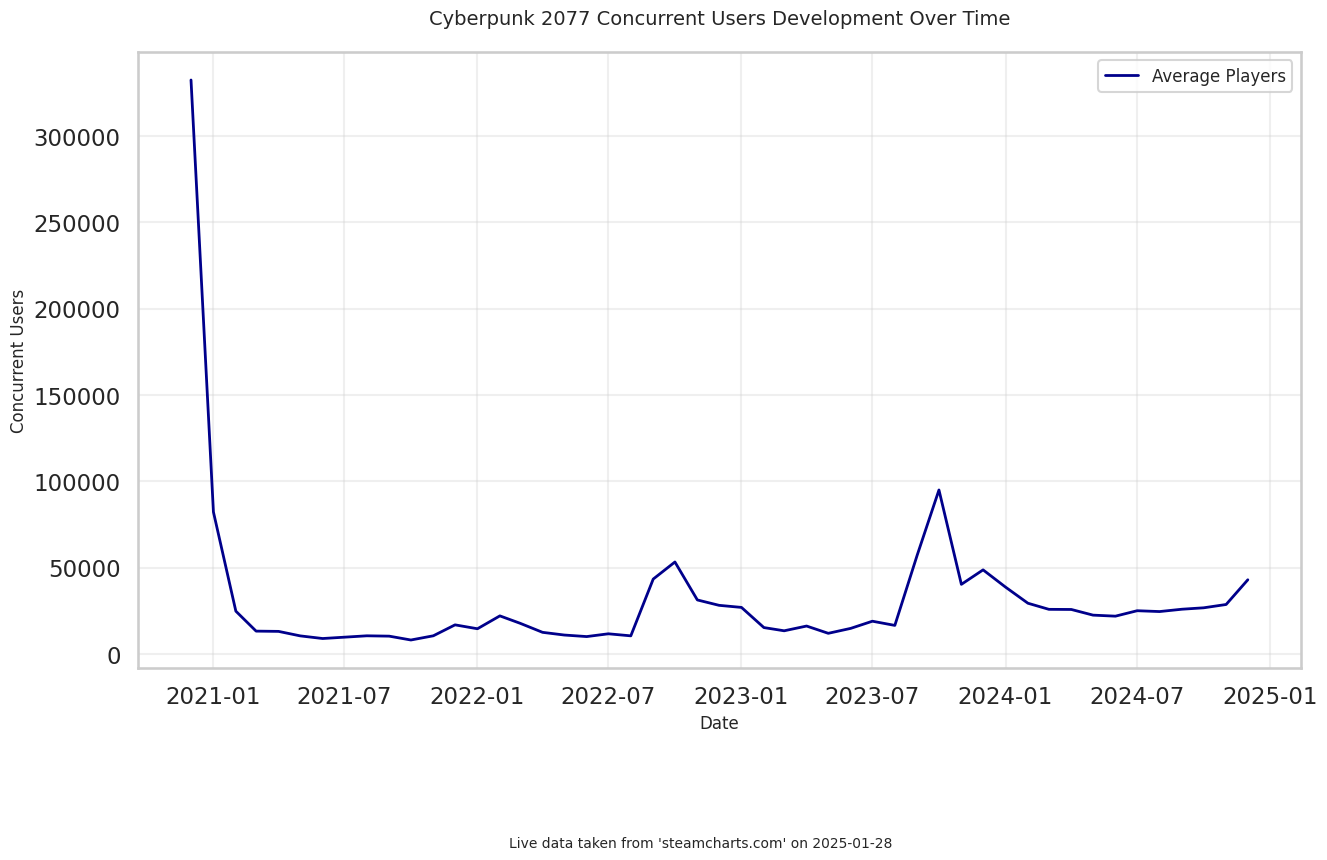

In [66]:
#@title Code

import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta

def fetch_game_name(appid):
    # Fetch game name using the Steam API
    url = f'https://store.steampowered.com/api/appdetails?appids={appid}&l=english'
    response = requests.get(url)
    data = response.json()

    # Extract game name
    if data.get(str(appid), {}).get('success'):
        game_name = data[str(appid)]['data']['name']
        return game_name
    else:
        return "Unknown Game"

def fetch_game_launch_date(appid):
    # Fetch game release date using Steam API
    url = f'https://store.steampowered.com/api/appdetails?appids={appid}&l=english'
    response = requests.get(url)
    data = response.json()

    # Extract release date
    if data.get(str(appid), {}).get('success'):
        release_date_timestamp = data[str(appid)]['data']['release_date']['coming_soon']
        release_date = datetime.fromtimestamp(release_date_timestamp)
        return release_date
    else:
        return None

def fetch_and_process_reviews(appid, months_range=0, smooth=True):
    url = f'https://store.steampowered.com/appreviewhistogram/{appid}?l=english'
    response = requests.get(url, headers={
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    })
    data = response.json()
    # print("Raw API Response:")
    # print(json.dumps(data, indent=2))

    # Extract monthly rollup data
    rollups = data['results']['rollups']

    # Convert to DataFrame
    df = pd.DataFrame(rollups)

    # Convert timestamp to datetime
    df['date'] = pd.to_datetime(df['date'], unit='s')

    # Determine the start date based on game launch date
    start_date = df['date'].min()

    # Calculate end date based on months_range
    if months_range > 0:
        end_date = start_date + timedelta(days=30*months_range)
    else:
        end_date = datetime.today()

    # Filter data by the start and end dates
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Calculate percentage of positive reviews
    df['positive_percentage'] = (df['recommendations_up'] /
                                 (df['recommendations_up'] + df['recommendations_down'])) * 100

    # Calculate cumulative percentage
    total_up = df['recommendations_up'].cumsum()
    total_down = df['recommendations_down'].cumsum()
    df['cumulative_positive_percentage'] = (total_up / (total_up + total_down)) * 100

    # Optionally smooth the data using a rolling mean (window size can be adjusted)
    if smooth:
        df['smoothed_positive_percentage'] = df['positive_percentage'].rolling(window=3, min_periods=1).mean()

    return df, start_date

print('Game Reviews:')

# Fetch and process the reviews
df, start_date = fetch_and_process_reviews(game_id, months_range, smooth)

# Fetch the game name dynamically
game_name = fetch_game_name(game_id)

# Create the plot
plt.figure(figsize=(15, 8))

# Plot the appropriate curve based on the smoothing option
if smooth:
    # Plot the smoothed monthly percentage
    plt.plot(df['date'], df['smoothed_positive_percentage'],
             label=f'Smoothed Monthly Positive % ({game_name})',
             alpha=0.7,
             color='lightblue',
             linestyle='-')
else:
    # Plot the raw monthly percentage
    plt.plot(df['date'], df['positive_percentage'],
             label=f'Raw Monthly Positive % ({game_name})',
             alpha=0.7,
             color='lightblue',
             linestyle='-')

# Plot the cumulative monthly percentage
plt.plot(df['date'], df['cumulative_positive_percentage'],
         label=f'Cumulative Positive % ({game_name})',
         linewidth=2,
         color='darkblue')

# Customize the plot
plt.title(f'{game_name} Steam Review Score Development Over Time', pad=20, fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Positive Reviews (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set y-axis limits to focus on the line and avoid a small line at the top
plt.ylim(40, 100)  # Adjust this range based on your data

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add the text below the plot
current_date = datetime.now().strftime('%Y-%m-%d')
plt.figtext(0.5, -0.1, f"Live data taken from 'store.steampowered.com' on {current_date}", ha='center', va='top', fontsize=10)


plt.show()

# print(f"Total reviews analyzed: {df['recommendations_up'].sum() + df['recommendations_down'].sum():,}")
print('Concurrent Users:')

# If smoothing is enabled, print smoothed statistics
if smooth:
    print(f"Latest smoothed positive percentage: {df['smoothed_positive_percentage'].iloc[-1]:.1f}%")
    print(f"Highest smoothed monthly positive percentage: {df['smoothed_positive_percentage'].max():.1f}%")
    print(f"Lowest smoothed monthly positive percentage: {df['smoothed_positive_percentage'].min():.1f}%")


import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Fetch the webpage
url = f"http://steamcharts.com/app/{game_id}"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Step 2: Parse the table
rows = soup.select('table.common-table tbody tr')
data = []

for row in rows:
    cells = row.find_all('td')
    if len(cells) >= 2:
        month = cells[0].text.strip()
        avg_players = cells[1].text.strip().replace(',', '')
        data.append((month, float(avg_players)))

# Step 3: Create a DataFrame
df = pd.DataFrame(data, columns=["Month", "Avg Players"])
df['Month'] = pd.to_datetime(df['Month'], errors='coerce', format='%B %Y')
df = df.dropna()  # Remove rows with invalid dates
df = df.sort_values('Month')  # Sort by date

# Filter data based on months_range
if months_range > 0:
    end_date = df['Month'].max()
    start_date = end_date - pd.DateOffset(months=months_range)
    df = df[df['Month'] >= start_date]

# Step 4: Plot the data
plt.figure(figsize=(15, 8))

# Plot the average players data
plt.plot(df['Month'], df['Avg Players'], label="Average Players", color='darkblue', linewidth=2)

# Customize the plot to match the desired style
plt.title(f"{game_name} Concurrent Users Development Over Time", pad=20, fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Concurrent Users", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add the text below the plot
current_date = datetime.now().strftime('%Y-%m-%d')
plt.figtext(0.5, -0.1, f"Live data taken from 'steamcharts.com' on {current_date}", ha='center', va='top', fontsize=10)


# Show the plot
plt.show()